In [3]:
import numpy as np
import os
import seaborn as sns
import scipy.stats as stat
from scipy.stats import pearsonr
from scipy.stats import pointbiserialr
import pandas as pd
import matplotlib.pyplot as plt
from pydataset import data
import warnings
warnings.filterwarnings("ignore")
import wrangle as wra
import env
import explore as exp
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression 
from math import sqrt
import statsmodels.api as sm

### 1. Load your zillow dataset.

In [4]:
zillow_query = """
        select bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt,
        taxamount, fips
        from properties_2017
        where propertylandusetypeid = '261';
        """

zillow_df = wra.get_zillow_data(zillow_query)

zillow_df.head()

,Unnamed: 0,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


In [5]:
df = zillow_df

In [6]:
df = wra.wrangle_zillow(df)

In [7]:
df.head()

,bedroomcnt,bathroomcnt,squarefeet,taxvalue,yearbuilt,taxamount,county
4,4,2.0,3633,296425,2005,6941.39,LA
6,3,4.0,1620,847770,2011,10244.94,LA
7,3,2.0,2077,646760,1926,7924.68,LA
11,0,0.0,1200,5328,1972,91.60,LA
14,0,0.0,171,6920,1973,255.17,LA


In [8]:
train, validate, test = wra.split_data(df)

### 2. Fit a linear regression model (ordinary least squares) and compute yhat, predictions of taxvaluedollarcnt using only calculatedfinishedsqft.

In [9]:
# Fit a linear regression model using OLS
X = sm.add_constant(df['squarefeet'])
model = sm.OLS(df['taxvalue'], X).fit()

# Compute the predicted values of 'taxvaluedollarcnt'
yhat = model.predict(X)

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               taxvalue   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                 7.663e+05
Date:                Wed, 10 May 2023   Prob (F-statistic):               0.00
Time:                        11:08:06   Log-Likelihood:            -2.7775e+07
No. Observations:             2033172   AIC:                         5.555e+07
Df Residuals:                 2033170   BIC:                         5.555e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        5.61e+04    379.799    147.711      0.0

In [20]:
#create baseline of y-target
baseline = train.taxvalue.mean()
baseline

363532.06723244983

In [21]:
# make it
lr = LinearRegression()

# fit it to training data
lr.fit(train[['squarefeet']], train.taxvalue)

# use it
# we will use lr.predict to make predictions 
lr.predict(train[['squarefeet']])

array([580049.24806397, 584607.35349842, 507294.8728601 , ...,
       379141.98545281, 302881.37529937, 331807.81363343])

In [22]:
train['yhat'] = lr.predict(train[['squarefeet']])
train.head()

,bedroomcnt,bathroomcnt,squarefeet,taxvalue,yearbuilt,taxamount,county,yhat,baseline_residual,residuals
1571798,4,2.5,2987,885000,2006,13617.38,Orange,580049.248064,521467.932768,304950.751936
1723553,3,2.0,3013,489511,1977,5768.57,LA,584607.353498,125978.932768,-95096.353498
718174,4,3.0,2572,390915,1986,4944.11,LA,507294.872860,27382.932768,-116379.872860
1663205,3,1.0,1589,321758,1959,4031.78,LA,334963.425088,-41774.067232,-13205.425088
1087891,3,2.0,1727,231737,1962,2708.80,Ventura,359156.446240,-131795.067232,-127419.446240


### 3. Plot the residuals for the linear regression model that you made

In [23]:
# residual = actual - predicted
train['baseline_residual'] = train.taxvalue - baseline

In [29]:
train.head()

,bedroomcnt,bathroomcnt,squarefeet,taxvalue,yearbuilt,taxamount,county,yhat,baseline_residual,residuals
1571798,4,2.5,2987,885000,2006,13617.38,Orange,580049.248064,521467.932768,304950.751936
1723553,3,2.0,3013,489511,1977,5768.57,LA,584607.353498,125978.932768,-95096.353498
718174,4,3.0,2572,390915,1986,4944.11,LA,507294.872860,27382.932768,-116379.872860
1663205,3,1.0,1589,321758,1959,4031.78,LA,334963.425088,-41774.067232,-13205.425088
1087891,3,2.0,1727,231737,1962,2708.80,Ventura,359156.446240,-131795.067232,-127419.446240


In [30]:
# residual = actual - predicted
train['residuals'] = train.yhat - train.taxvalue
train.head()

,bedroomcnt,bathroomcnt,squarefeet,taxvalue,yearbuilt,taxamount,county,yhat,baseline_residual,residuals
1571798,4,2.5,2987,885000,2006,13617.38,Orange,580049.248064,521467.932768,-304950.751936
1723553,3,2.0,3013,489511,1977,5768.57,LA,584607.353498,125978.932768,95096.353498
718174,4,3.0,2572,390915,1986,4944.11,LA,507294.872860,27382.932768,116379.872860
1663205,3,1.0,1589,321758,1959,4031.78,LA,334963.425088,-41774.067232,13205.425088
1087891,3,2.0,1727,231737,1962,2708.80,Ventura,359156.446240,-131795.067232,127419.446240


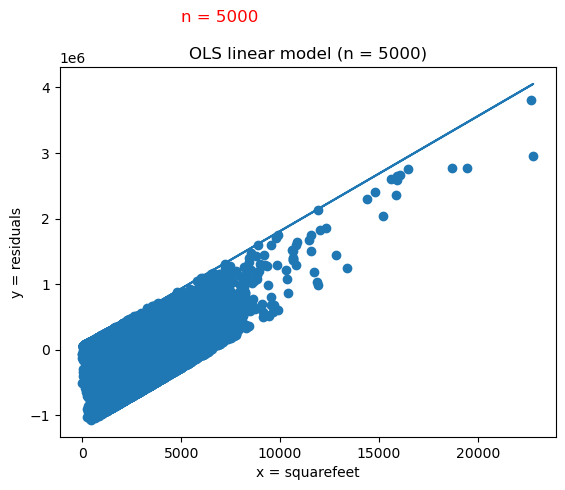

In [31]:
# visualize the line of best fit from OLS linear model

# scatter is my actuals
plt.scatter(train.squarefeet, train.residuals)

# lineplot is my regression line
plt.plot(train.squarefeet, train.yhat)

plt.xlabel('x = squarefeet')
plt.ylabel('y = residuals')
plt.title('OLS linear model (n = 5000)')
plt.text(5000, 5000000, 'n = 5000', fontsize=12, color='red')

plt.show()

### 4. Calculate the sum of squared errors, explained sum of squares, total sum of squares, mean squared error, and root mean squared error for your model.